# 1. PBMC data of immune cells from young and old, male and female samples

Huang, Zhaohao, Binyao Chen, Xiuxing Liu, He Li, Lihui Xie, Yuehan Gao, Runping Duan, et al. 2021. “Effects of Sex and Aging on the Immune Cell Landscape as Assessed by Single-Cell Transcriptomic Analysis.” Proceedings of the National Academy of Sciences of the United States of America 118 (33). https://doi.org/10.1073/pnas.2023216118.

In [1]:
import os
import sys
import pandas as pd

# Scanpro functions
from scanpro import scanpro
from scanpro.utils import convert_counts_to_df

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------------------

## Read data

In [3]:
pbmc_counts = pd.read_csv("data/pbmc_counts.tsv", sep="\t")

In [4]:
pbmc_counts.head()

,Sample,Condition,Sex,Age,B cells,Dendritic cells,Monocytes,NK cells,T cells
0,OF1,OF,Female,Old,1449,135,1342,1328,4574
1,OF2,OF,Female,Old,677,148,2159,746,5097
2,OF3,OF,Female,Old,552,124,1507,1108,5535
3,OF4,OF,Female,Old,666,146,1277,589,6151
4,OF5,OF,Female,Old,653,137,2027,1632,4379


In [5]:
# Convert count matrix to long format
pbmc = convert_counts_to_df(pbmc_counts, column_name="Celltype")
pbmc.head()

,Sample,Condition,Sex,Age,Celltype
cell_1,OF1,OF,Female,Old,B cells
cell_2,OF1,OF,Female,Old,B cells
cell_3,OF1,OF,Female,Old,B cells
cell_4,OF1,OF,Female,Old,B cells
cell_5,OF1,OF,Female,Old,B cells


-------

## Run Scanpro

### Young vs Old

In [6]:
pbmc_young_old = scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Age')
pbmc_young_old.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_Old,mean_props_Young,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
B cells,0.098383,0.094222,0.102401,0.920131,-0.820489,0.415800,0.519750
Dendritic cells,0.017112,0.016362,0.018018,0.908097,-0.251112,0.802748,0.802748
Monocytes,0.171416,0.196655,0.143211,1.373180,2.608123,0.011948,0.059738
NK cells,0.146479,0.158121,0.133477,1.184627,1.081533,0.284606,0.474344
T cells,0.566610,0.534640,0.602892,0.886791,-1.780506,0.081019,0.202548


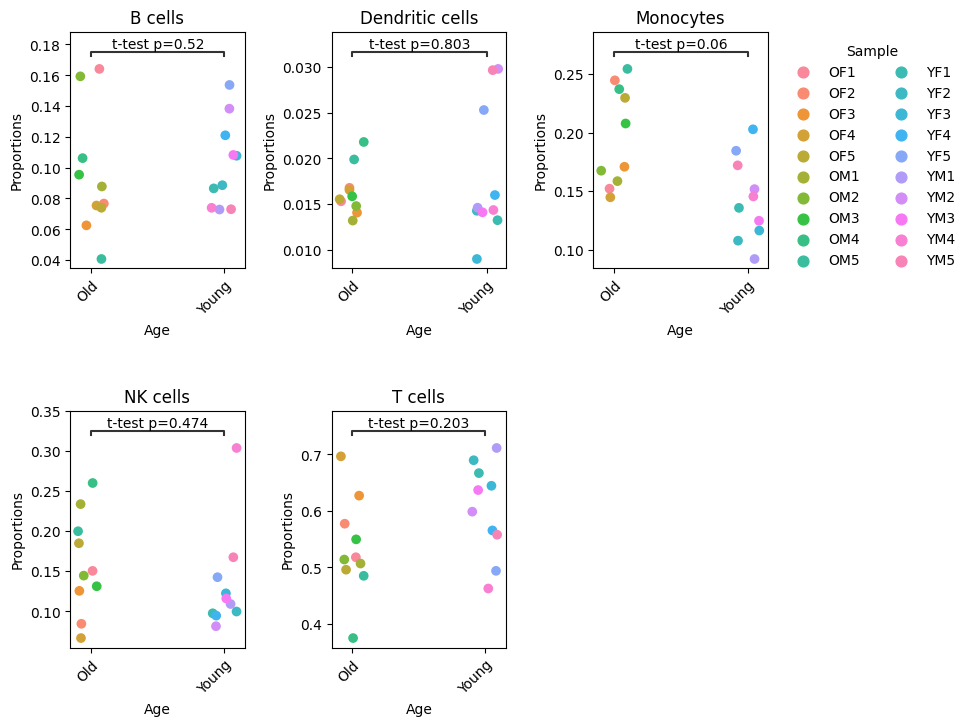

In [7]:
pbmc_young_old.plot(save="plots/pbmc_age_stripplot.pdf")

#### With sex as covariate

In [8]:
pbmc_young_old_sex = scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Age', 
                             covariates=["Sex"])
pbmc_young_old_sex.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_Old,mean_props_Young,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
B cells,0.098383,0.094222,0.102401,0.920131,-0.847305,0.399205,0.499006
Dendritic cells,0.017112,0.016362,0.018018,0.908097,-0.240203,0.810751,0.810751
Monocytes,0.171416,0.196655,0.143211,1.373180,2.446304,0.016494,0.082471
NK cells,0.146479,0.158121,0.133477,1.184627,1.220507,0.225648,0.376080
T cells,0.566610,0.534640,0.602892,0.886791,-1.782987,0.078158,0.195396


### Male vs Female

In [9]:
pbmc_male_female = scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex')
pbmc_male_female.results.to_csv("results/pbmc_scanpro_rep_logit.tsv", sep="\t")
pbmc_male_female.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_Female,mean_props_Male,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
B cells,0.098383,0.101042,0.095581,1.057138,0.453598,0.651210,0.814013
Dendritic cells,0.017112,0.015587,0.018793,0.829422,-1.054917,0.294287,0.490479
Monocytes,0.171416,0.168821,0.171046,0.986995,-0.063599,0.949430,0.949430
NK cells,0.146479,0.116914,0.174684,0.669285,-2.636203,0.009874,0.049371
T cells,0.566610,0.597636,0.539896,1.106946,1.447690,0.151178,0.377946


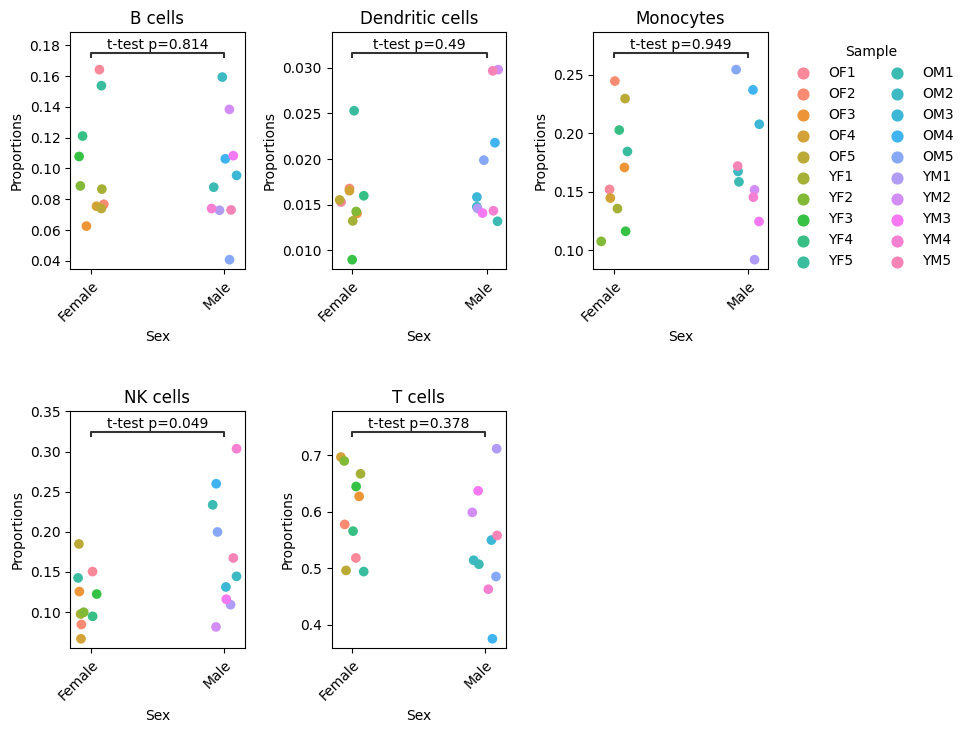

In [10]:
pbmc_male_female.plot(save=f"{FIG_PATH}/pbmc_sex_stripplot.pdf")

In [11]:
pbmc_male_female_arcsin = scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex', transform="arcsin")
pbmc_male_female_arcsin.results.to_csv("results/pbmc_scanpro_rep_arcsin.tsv", sep="\t")

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


#### With age as covariate

In [12]:
pbmc_male_female_age = scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex', covariates="Age")
pbmc_male_female_age.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_Female,mean_props_Male,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
B cells,0.098383,0.101042,0.095581,1.057138,0.466193,0.642270,0.802838
Dendritic cells,0.017112,0.015587,0.018793,0.829422,-1.094385,0.276878,0.461463
Monocytes,0.171416,0.168821,0.171046,0.986995,-0.066020,0.947517,0.947517
NK cells,0.146479,0.116914,0.174684,0.669285,-2.699387,0.008380,0.041900
T cells,0.566610,0.597636,0.539896,1.106946,1.496382,0.138258,0.345645


## Run Scanpro without replicates

In [13]:
pbmc_male_female_norep = scanpro(pbmc, clusters_col='Celltype', conds_col='Sex')
pbmc_male_female_norep.results.to_csv("results/pbmc_scanpro_norep_logit.tsv", sep="\t")

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 46.08 seconds


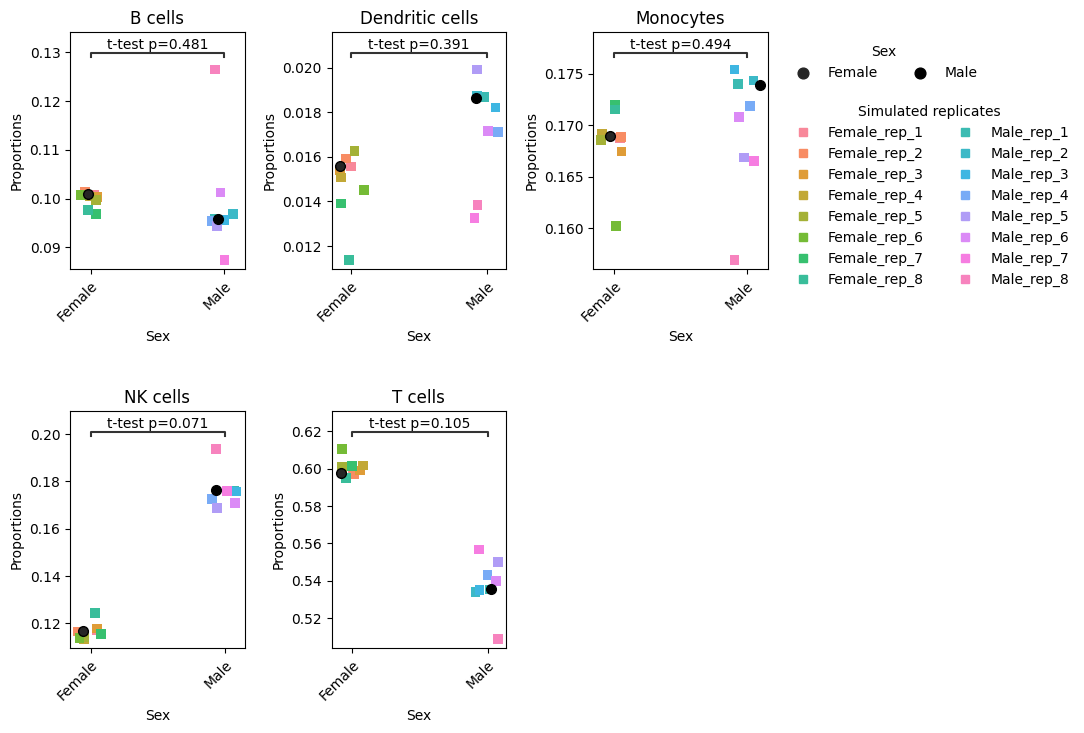

In [14]:
pbmc_male_female_norep.plot(save="plots/pbmc_sex_norep_stripplot.pdf")

In [15]:
pbmc_male_female_norep_arcsin = scanpro(pbmc, clusters_col='Celltype', conds_col='Sex', transform="arcsin")
pbmc_male_female_norep_arcsin.results.to_csv("results/pbmc_scanpro_norep_arcsin.tsv", sep="\t")

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 45.74 seconds


-----------------------

## Run propeller

In [16]:
# Setup path to R
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [17]:
%%R -i pbmc -o propeller_results_logit -o propeller_results_arcsin
library(speckle)

propeller_results_logit = propeller(clusters = pbmc$Celltype, sample = pbmc$Sample, group = pbmc$Sex, transform="logit")
propeller_results_arcsin = propeller(clusters = pbmc$Celltype, sample = pbmc$Sample, group = pbmc$Sex, transform="asin")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed
Performing arcsin square root transformation of proportions
group variable has 2 levels, t-tests will be performed


In [18]:
propeller_results_logit

,BaselineProp.clusters,BaselineProp.Freq,PropMean.Female,PropMean.Male,PropRatio,Tstatistic,P.Value,FDR
NK cells,NK cells,0.146479,0.116914,0.174684,0.669285,-2.637317,0.009844,0.049221
T cells,T cells,0.566610,0.597636,0.539896,1.106946,1.448420,0.150975,0.377437
Dendritic cells,Dendritic cells,0.017112,0.015587,0.018793,0.829422,-1.052536,0.295371,0.492285
B cells,B cells,0.098383,0.101042,0.095581,1.057138,0.453546,0.651248,0.814059
Monocytes,Monocytes,0.171416,0.168821,0.171046,0.986995,-0.063694,0.949355,0.949355


In [19]:
propeller_results_logit.to_csv("results/pbmc_propeller_rep_logit.tsv", sep="\t")
propeller_results_arcsin.to_csv("results/pbmc_propeller_rep_arcsin.tsv", sep="\t")

-------------

## Run scCODA

### Data preparation

In [20]:
import pertpy as pt
import anndata as ad

Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.9

In [21]:
sccoda_adata = ad.AnnData(obs=pbmc)

### With replicates

In [22]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="Celltype", 
                                sample_identifier="Sample", covariate_obs=["Sex"])
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="Sex", reference_cell_type="Monocytes")

<Axes: xlabel='Cell type', ylabel='Proportion'>

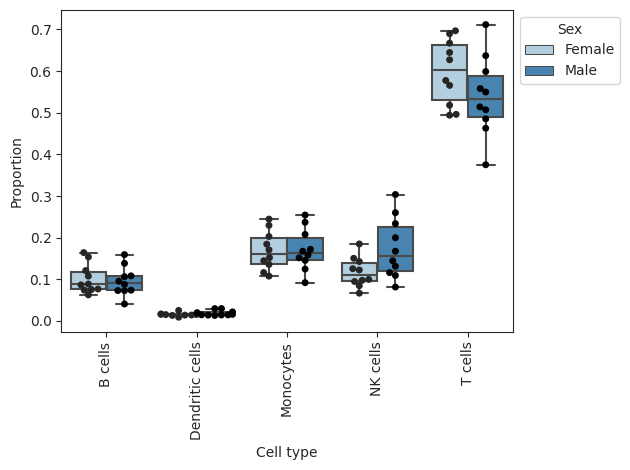

In [23]:
pt.pl.coda.boxplots(sccoda_data, modality_key="coda", feature_name="Sex", add_dots=True)

In [24]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 11000/11000 [01:12<00:00, 152.75it/s, 95 steps of size 3.74e-02. acc. prob=0.77] 


In [25]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.3)
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 20 samples, 5 cell types                                    │
│ Reference cell type                         │ Monocytes                                                         │
│ Formula                                     │ Sex                                                               │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                  Final Parameter  Expected Sample                                                               │
│ Cell Type                                                                                                       │
│ B cells              1.870            866.777                                                                   │
│ Dendritic cells      0.391            197.509                                                                   │
│ Monocytes            2.396           1466.717                                                                   │
│ NK cells             2.115           1107.413                                                                   │
│ T cells              3.639           5083.635                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                            Final Parameter  Expected Sample  log2-fold change                                   │
│ Covariate Cell Type                                                                                             │
│ SexT.Male B cells              0.000            834.174           -0.055                                        │
│           Dendritic cells      0.000            190.079           -0.055                                        │
│           Monocytes            0.000           1411.548           -0.055                                        │
│           NK cells             0.268           1393.829            0.332                                        │
│           T cells              0.000           4892.420           -0.055                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [26]:
credible_effects = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
credible_effects

credible_effect
Covariate   Cell Type                       
Sex[T.Male] B cells                    False
            Dendritic cells            False
            Monocytes                  False
            NK cells                    True
            T cells                    False

In [27]:
credible_effects.to_csv("results/pbmc_sccoda_rep.tsv", sep="\t")

### Without replicates

In [28]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="Celltype", 
                                sample_identifier="Sex", covariate_obs=["Sex"])
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="Sex", reference_cell_type="Monocytes")

In [29]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [00:14<00:00, 741.25it/s, 31 steps of size 5.36e-02. acc. prob=0.65]  


In [30]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 2 samples, 5 cell types                                    │
│ Reference cell type                          │ Monocytes                                                        │
│ Formula                                      │ Sex                                                              │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                  Final Parameter  Expected Sample                                                               │
│ Cell Type                                                                                                       │
│ B cells              3.362           8688.447                                                                   │
│ Dendritic cells      1.591           1478.450                                                                   │
│ Monocytes            3.912          15059.276                                                                   │
│ NK cells             3.624          11290.867                                                                   │
│ T cells              5.126          50703.460                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                            Final Parameter  Expected Sample  log2-fold change                                   │
│ Covariate Cell Type                                                                                             │
│ SexT.Male B cells              0.000           8688.447           0.000                                         │
│           Dendritic cells      0.000           1478.450           0.000                                         │
│           Monocytes            0.000          15059.276           0.000                                         │
│           NK cells             0.000          11290.867           0.000                                         │
│           T cells              0.000          50703.460           0.000                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [31]:
credible_effects = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
credible_effects

credible_effect
Covariate   Cell Type                       
Sex[T.Male] B cells                    False
            Dendritic cells            False
            Monocytes                  False
            NK cells                   False
            T cells                    False

In [32]:
credible_effects.to_csv("results/pbmc_sccoda_norep.tsv", sep="\t")